# Lotka Volterra Sensitivity and Uncertainty Analysis

This tutorial will cover the application of sensitivity and uncertainty methods on Lotka Volterra, composed of ordinary differential equations.

The purpose of an uncertainty analysis is to quantify how uncertainty in the model inputs propagates to uncertainty in the model outputs. It is *output focused*, so we are more so interested in quantifying the uncertainty of the model outputs.

A closely related concept is a sensitivity analysis, which quantifies our variation in each of our inputs causes the most variation in the model outputs. It is *input focused*, so we are interested in quantifying the identifying the model inputs that most greatly influence the outputs.

# Imports

We will first import all required dependencies.

In [4]:
import pandas as pd
import numpy as np
from calisim.example_models import LotkaVolterraModel
import os.path as osp

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
from calisim.statistics import MeanSquaredError

# Observed data

We will next load the observed field data.

In [5]:
model = LotkaVolterraModel()
observed_data = model.get_observed_data()
observed_data

,year,lynx,hare
0,1900.0,4.0,30.0
1,1901.0,6.1,47.2
2,1902.0,9.8,70.2
3,1903.0,35.2,77.4
4,1904.0,59.4,36.3
5,1905.0,41.7,20.6
6,1906.0,19.0,18.1
7,1907.0,13.0,21.4
8,1908.0,8.3,22.0
9,1909.0,9.1,25.4


# Calibration procedure

## Uncertainty analysis

We will next run the calibration procedures against predator population (Lynx) data. In this case, we will start with an uncertainty analysis.

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- α (alpha): Prey birth rate: how fast the hares multiply when there's no danger.
- β (beta): Predation rate: how often lynxes successfully consume prey.

In [7]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="alpha",
			distribution_name="uniform",
			distribution_args=[0.4, 0.55],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.02, 0.03],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll construct a function for our uncertainty analysis, which will return a vector of Lynx population data.

In [8]:
def uncertainty_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = LotkaVolterraModel()
    simulation_parameters = dict(h0=34.0, l0=5.9, t=t, gamma=0.84, delta=0.026)
    
    for k in ["alpha", "beta"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).lynx.values
    return simulated_data

[We next run the uncertainty analysis using the Chaospy library](https://chaospy.readthedocs.io/en/master/).

Chaospy will perform a Monte Carlo simulation as determined by the joint distribution of our parameter specification. It will then fit a polynomial chaos expansion (PCE) surrogate model that learns the relationship between the model inputs and outputs. More specifically, Polynomial Chaos Expansion (PCE) approximates a complex model 

$$
Y = f(X_1, X_2, \dots, X_n)
$$

as a polynomial of the uncertain inputs:

$$
Y \approx \sum_{i} c_i \, \Psi_i(X_1, X_2, \dots, X_n)
$$

where:  
- $X_1, X_2, \dots, X_n$ are the **uncertain input variables**.  
- $\Psi_i$ are **orthogonal polynomials** chosen according to the input distributions:  
  - Hermite polynomials for Normal distributions  
  - Legendre polynomials for Uniform distributions  
- $c_i$ are **coefficients** fitted from the model outputs.
- $i$ are the terms in the polynomial expansion.

A secondary benefit of surrogate modelling is that we speed up the uncertainty analysis by reducing the number of executions of the simulation model; our PCE model acts as a cheaper surrogate of the full model. [A more detailed tutorial on PCE can be found here](https://maths-people.anu.edu.au/~jakeman/QuantifyingUncertainty/Tutorials/PCtutorial.html).

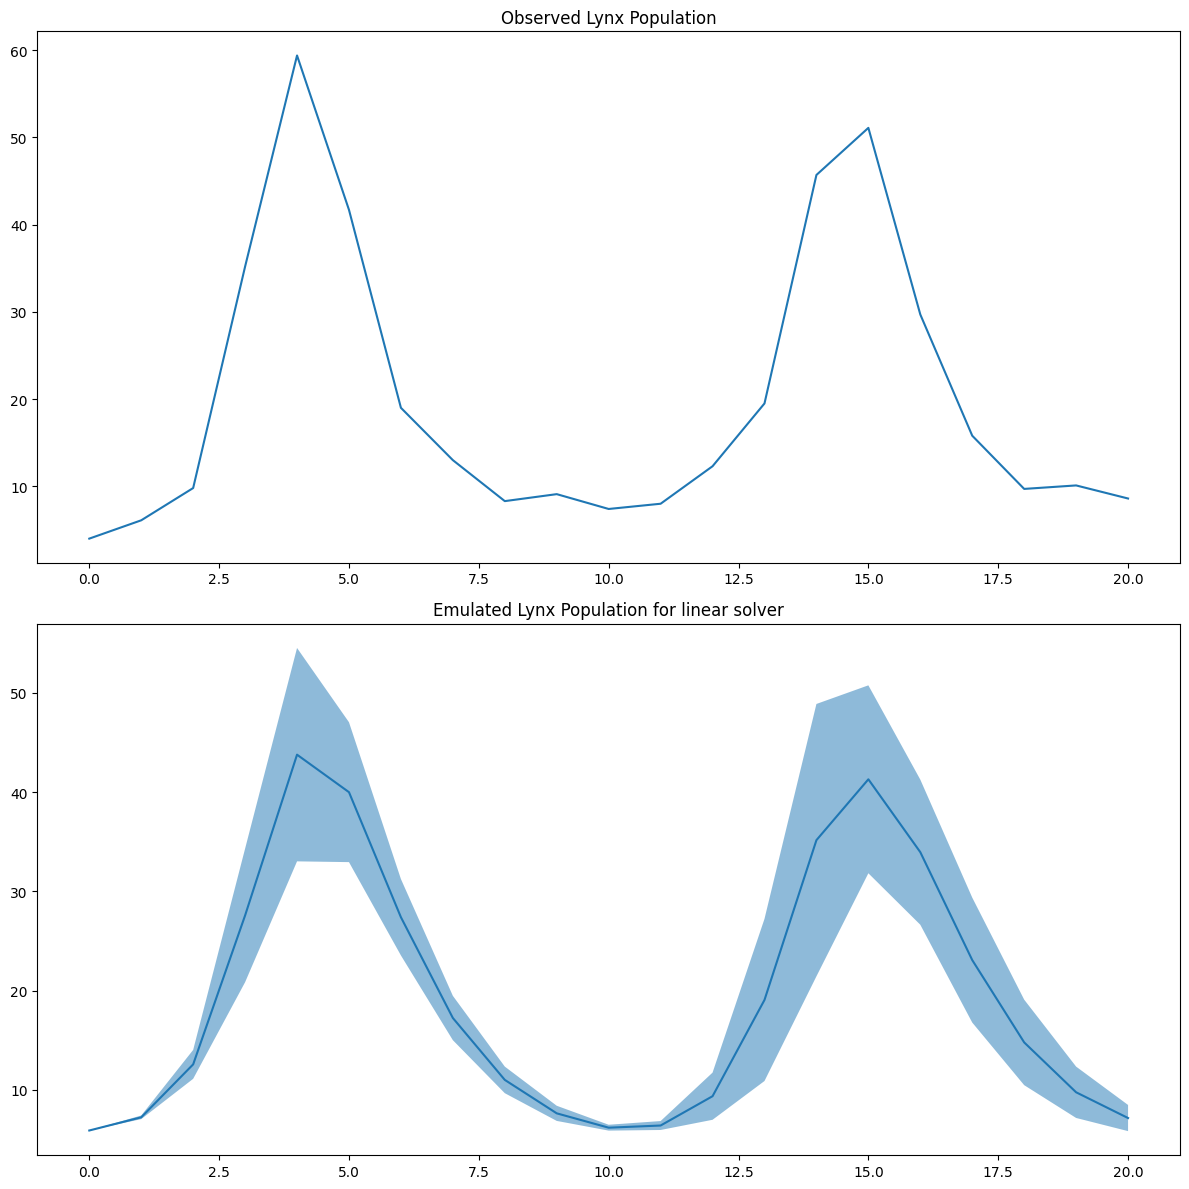

In [10]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.lynx.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=200,
	output_labels=["Lynx Population"],
	flatten_Y=True,
	batch=False,
	method_kwargs=dict(rule="cholesky", normed=False, cross_truncation=1.0),
    calibration_func_kwargs=dict(t=observed_data.year),
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see the results of the uncertainty analysis above. We have a deterministic and mechanistic ODE model, and by using a PCE surrogate model, we are able to construct a distribution of plausible trajectories for the Lynx population. We have the mean trajectory of our predicted population data, alongside its standard deviation.

An uncertainty analysis is particulary useful for both temporal and spatial modelling (in our case temporal), as it tracks how uncertainty in model inputs or conditions spreads and evolves across both space and time. It helps reveal where and when predictions are most reliable in dynamic, location-dependent systems.

## Sensitivity analysis

We will next perform a sensitivity analysis to derive sensitivity indices for our 2 parameters (alpha and beta). This will allow us to prioritise specific parameters for calibration using a combination of a data-driven approach (with our observed Lynx population data), consultation with domain experts, and a review of the available literature.

We will calculate Sobol sensitivity indices to quantify how the variation in the 2 input parameters of the model influences the variation in Lynx population trajectories. [A detailed explaination of the Sobol methods may be found here.](https://link.springer.com/chapter/10.1007/978-3-030-51862-2_6). 

We'll first define a sensitivity analysis function which will return the discrepancy between observed and simulated Lynx population values as determined by the mean squared error (MSE) metric. There are alternatives...we could return sensitivity indices for each time step if we wanted to perform a time-varying sensitivity analysis for instance. But we'll keep things simple.

In [13]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = LotkaVolterraModel()
    simulation_parameters = dict(h0=34.0, l0=5.9, t=t, gamma=0.84, delta=0.026)
    
    for k in ["alpha", "beta"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).lynx.values
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We'll use the Sobol method from the SALib library](https://salib.readthedocs.io/en/latest/), and take 250 base samples. We'll construct bootstrap confidence intervals for our sensitivity indices.

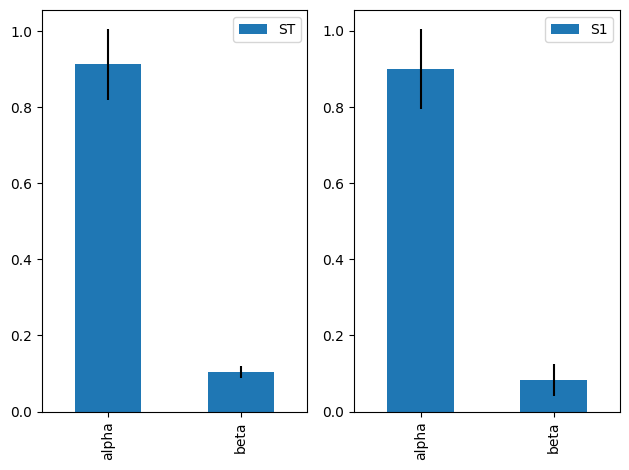

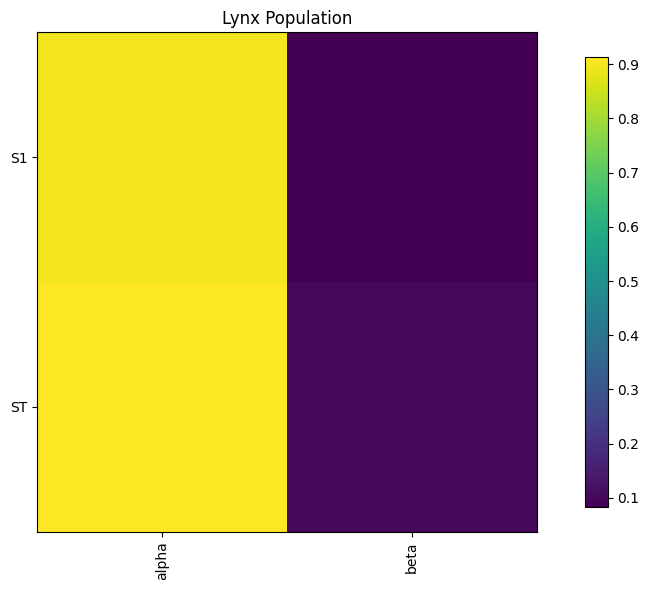

In [14]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.lynx.values,
	method="sobol",
	n_samples=500,
    n_jobs=1,
	output_labels=["Lynx Population"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=False, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=False,
		num_resamples=300,
		conf_level=0.95,
	),
    calibration_func_kwargs=dict(t=observed_data.year),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

The variation in the discrepancy between simulated and observed Lynx population data (the output) is most sensitive to variation in alpha (the input), which is the prey birth rate: how fast the hares multiply when there’s no danger.

It appears that the varation in beta has less of an influence.

Hence, we would want to focus on calibrating alpha first. To reduce the possibility of overfitting, we may hold less influential parameters, such as beta, constant while varying more influential parameters such as alpha.